주제: 전이학습과 텐서플로우라이트로 변환 및 라즈베리파이에서의 테스트 검증  
이 파일에서는 아래와 같은 주요 기능이 수행됩니다. 
1. tensorflow 데이터세트에서 catvsdog를 선택합니다.  
2. (in Kaggle) MobilenetV2의 feature vector model을 나의 모델에 애드온 합니다. 
https://www.kaggle.com/models/google/mobilenet-v2/frameworks/tensorFlow2/variations/tf2-preview-feature-vector
3. 트레이닝 데이터 세트를 훈련시켜 모델을 완성합니다. 
4. 트레이닝을 마친 최종 모델을 최적화를 거쳐 텐서플로우 라이트로 변환합니다. 
6. (라즈베리파이)테스트 데이터로 최종 검증 결과를 확인합니다. 
-------------
tensorflow dataset(https://www.tensorflow.org/datasets?hl=ko)으로 kaggle(https://www.kaggle.com/)에 있는 feature vector model을 적용시켜 테스트한 결과 입니다. 

In [ ]:
#colab에서 돌린것이라 명령어 앞에 !을 붙임 
!python -m  pip install tflite-runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 11.8 MB/s eta 0:00:00


In [ ]:
######################################
# 1-1. 기본: 텐서플로우 라이트로 변환하기
####################################

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten,Dense
from tensorflow.keras.optimizers import Adam
import pathlib

myLayer = Dense(units=1, input_shape=[1])
model = Sequential([myLayer])
model.compile(
    optimizer='sgd',
    loss = 'mean_squared_error'
)

xs = np.array([-1.0,0.0,1.0,2.0,3.0,4.0],dtype=float)
ys = np.array([-3.0,-1.0,1.0,3.0,5.0,7.0],dtype = float)

model.fit(xs,ys,epochs=500, verbose=0)

print(model.predict([10.0]))
print("학습된 가중치: {}".format(myLayer.get_weights()))
print("get Config: {}".format(myLayer.get_config()))

#모델 저장하기
export_dir='/content/drive/MyDrive/INTEL_PYTHON/saved_model/1' #디렉토리 생성해줌
tf.saved_model.save(model,export_dir)


#모델 변환하기
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert() #tflite 모델로 저장하기

#.tflite 모델로 저장하기
tflite_model_file = pathlib.Path('/content/drive/MyDrive/INTEL_PYTHON/model.tflite')
tflite_model_file.write_bytes(tflite_model)





Epoch 1/500
1/1 [==============================] - 0s 296ms/step - loss: 3.6283
Epoch 2/500
1/1 [==============================] - 0s 12ms/step - loss: 3.0169
Epoch 3/500
1/1 [==============================] - 0s 9ms/step - loss: 2.5325
Epoch 4/500
1/1 [==============================] - 0s 12ms/step - loss: 2.1481
Epoch 5/500
1/1 [==============================] - 0s 17ms/step - loss: 1.8425
Epoch 6/500
1/1 [==============================] - 0s 10ms/step - loss: 1.5989
Epoch 7/500
1/1 [==============================] - 0s 9ms/step - loss: 1.4042
Epoch 8/500
1/1 [==============================] - 0s 15ms/step - loss: 1.2481
Epoch 9/500
1/1 [==============================] - 0s 14ms/step - loss: 1.1222
Epoch 10/500
1/1 [==============================] - 0s 11ms/step - loss: 1.0204
Epoch 11/500
1/1 [==============================] - 0s 8ms/step - loss: 0.9374
Epoch 12/500
1/1 [==============================] - 0s 8ms/step - loss: 0.8694
Epoch 13/500
1/1 [==============================] - 

1092

In [ ]:
######################################
# 1-2. 기본: tflite 생성 후, 결과 확인
####################################

#import tensorflow as tf
import tflite_runtime.interpreter as tflite
import numpy as np

#모델 로드
interpreter = tflite.Interpreter(model_path='/content/drive/MyDrive/INTEL_PYTHON/model.tflite')
#텐서 할당
interpreter.allocate_tensors()

#모델이 기대하는 입력 데이터 포맷
input_details = interpreter.get_input_details()
#모델이 기대하는 출력 데이터 포맷
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)

#입력 데이터(x=10.0)에 대한 y를 예측하려면 입력 배열의 크기와 타입 정의  필요
to_predict =  np.array([[10.0]],dtype = np.float32)
print(to_predict)

#입력 값을 넣기 위한 입력 텐서 설정
interpreter.set_tensor(input_details[0]['index'], to_predict)
interpreter.invoke()

#출력 값을 반환 받을 출력 텐서 설정
tflite_results = interpreter.get_tensor(output_details[0]['index'])
print(tflite_results)

[{'name': 'serving_default_dense_1_input:0', 'index': 0, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 3, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[[10.]]
[[18.984905]]


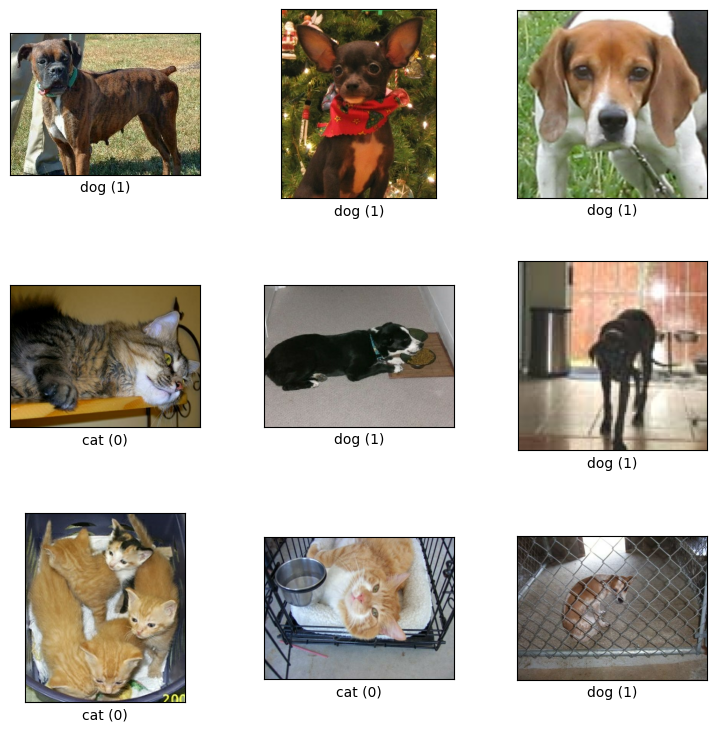

In [ ]:
###############################
# 2-2. 전이학습으로 모델 구현 및 metadata 확인
################################

import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

#244x 244 사이즈로 리사이즈를 하고, 정규화를 해줍니다.
def format_image(image,label):
    image = tf.image.resize(image,(224,224))/255.0
    return image, label

#훈련, 검증, 테스트 세트로 나눕니다.
(raw_train, raw_validation, raw_test), metadata =tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]','train[80%:90%]','train[90%:]'],
    with_info=True,#if True, tfds.load will return the tuple (tf.data.Dataset, tfds.core.DatasetInfo),
    as_supervised=True,#if True, the returned tf.data.Dataset will have a 2-tuple structure (input, label)
)

fig = tfds.show_examples(raw_train, metadata)

In [ ]:
###############################
# 2-2. 전이학습으로 모델 구현 및 metadata 확인
################################

import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

#244x 244 사이즈로 리사이즈를 하고, 정규화를 해줍니다.
def format_image(image,label):
    image = tf.image.resize(image,(224,224))/255.0
    return image, label

#훈련, 검증, 테스트 세트로 나눕니다.
(raw_train, raw_validation, raw_test), metadata =tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]','train[80%:90%]','train[90%:]'],
    with_info=True,#if True, tfds.load will return the tuple (tf.data.Dataset, tfds.core.DatasetInfo),
    as_supervised=True,#if True, the returned tf.data.Dataset will have a 2-tuple structure (input, label)
)



num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes
_label = metadata.features['label']

print('metadata:',metadata)
print('num_examples',num_examples)
print('num_classes',num_classes)



metadata: tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/root/tensorflow_datasets/cats_vs_dogs/4.0.1',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon 

['cat', 'dog']


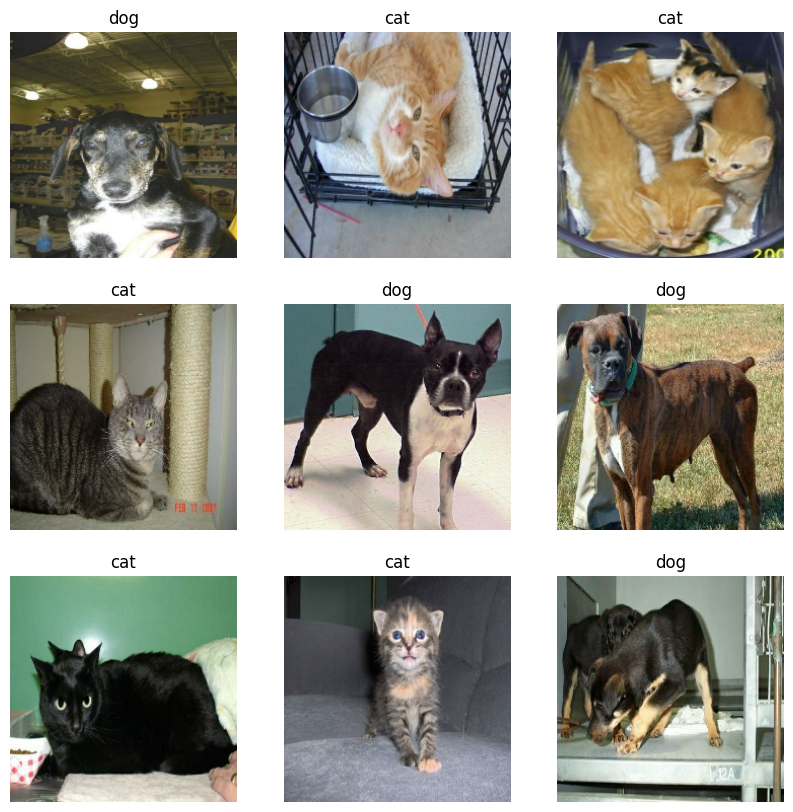

In [ ]:
###############################
# 2-3. 전이학습으로 모델 구현 + train/validation/test dataset 분리
################################

BATCH_SIZE = 32
class_names = ['cat','dog']
print(class_names)

#244x 244 사이즈로 리사이즈를 하고, 정규화를 해줍니다.
def resize_img(image,label):
    image = tf.image.resize(image,(224,224))
    return image, label

train_samples = raw_train.shuffle(10).map(resize_img).batch(10)

plt.figure(figsize=(10, 10))
for images, labels in train_samples.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

train_batches = raw_train.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
#examples.batch(20).prefetch(1) will prefetch 1 elements (2 batches, of 20 examples each).
validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = raw_test.map(format_image).batch(1)





In [ ]:
#텐서플로우 허브에 있는 mobilenet_v2 모델을 사용해 feature_extractor라는 케라스 층을 만듭니다.
#신경망의 첫번째 층

handle_base, pixels, FV_SIZE = ("mobilenet_v2", 224, 1280)

MODULE_HANDLE = "https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)

IMAGE_SIZE =(pixels, pixels)


feature_extractor = hub.KerasLayer(
    MODULE_HANDLE,
    input_shape = IMAGE_SIZE +(3,),
    output_shape = [FV_SIZE],
    trainable = False
)

# 모델 선언
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(num_classes, activation ='softmax')
])

In [ ]:
###############################
# 케라스 허브에서 모델 가져오기
# https://www.kaggle.com/
# mobilenet 검색 (_ v2)
################################

import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

#244x 244 사이즈로 리사이즈를 하고, 정규화를 해줍니다.
def format_image(image,label):
    image = tf.image.resize(image,(224,224))/255.0
    return image, label

#훈련, 검증, 테스트 세트로 나눕니다.
(raw_train, raw_validation, raw_test), metadata =tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]','train[80%:90%]','train[90%:]'],
    with_info=True,
    as_supervised=True,
)

print(metadata)

num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes


BATCH_SIZE = 32
train_batches = raw_train.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)

test_batches = raw_test.map(format_image).batch(1)


####################
#케라스 허브에서 모델 가져오기
###################
model = tf.keras.Sequential([
    hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/tf2-preview-feature-vector/versions/4",
                   input_shape = (224,224,3),
                   output_shape=[1280],
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss ='sparse_categorical_crossentropy',
    metrics =['accuracy']
)

hist = model.fit(
    train_batches,
    epochs = 5,
    validation_data = validation_batches
)

model.summary()

#학습된 모델 저장하기
CATS_VS_DOGS_SAVED_MODEL = "/content/drive/MyDrive/INTEL_PYTHON/exp_saved_model"
tf.saved_model.save(model, CATS_VS_DOGS_SAVED_MODEL)

#tensoflow lite로 변환하기
converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)
tflite_model = converter.convert()
tflite_model_file = '/content/drive/MyDrive/INTEL_PYTHON/converted_model.tflite'

#with open(…) as f 에서 f는 open(…)함수가 리턴한 file object.
with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)


interpreter = tf.lite.Interpreter(model_content=tflite_model)
input_details = interpreter.get_input_details()[0]
print('input: ', input_details)
output_details = interpreter.get_output_details()[0]
print('output: ', output_details)



Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.1.incompleteE2WASP/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir=PosixGPath('/tmp/tmpupyol7b7tfds'),
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-in

In [ ]:
###############################
#.tflite로 변환후 추론 테스트
################################

import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

#244x 244 사이즈로 리사이즈를 하고, 정규화를 해줍니다.
def format_image(image,label):
    image = tf.image.resize(image,(224,224))/255.0
    return image, label

#훈련, 검증, 테스트 세트로 나눕니다.
(raw_train, raw_validation, raw_test), metadata =tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]','train[80%:90%]','train[90%:]'],
    with_info=True,
    as_supervised=True,
)


num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes

BATCH_SIZE = 32
train_batches = raw_train.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
#examples.batch(20).prefetch(1) will prefetch 1 elements (2 batches, of 20 examples each).

validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)

test_batches = raw_test.map(format_image).batch(1)

#텐서플로우 허브에 있는 mobilenet_v2 모델을 사용해 feature_extractor라는 케라스 층을 만듭니다.
#신경망의 첫번째 층
handle_base, pixels, FV_SIZE = ("mobilenet_v2", 224, 1280)

MODULE_HANDLE = "https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)

IMAGE_SIZE =(pixels, pixels)


feature_extractor = hub.KerasLayer(
    MODULE_HANDLE,
    input_shape = IMAGE_SIZE +(3,),
    output_shape = [FV_SIZE],
    trainable = False
)

# 모델 선언
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(num_classes, activation ='softmax')
])

model.compile(
    optimizer='adam',
    loss ='sparse_categorical_crossentropy',
    metrics =['accuracy']
)

hist = model.fit(
    train_batches,
    epochs = 5,
    validation_data = validation_batches
)

#학습된 모델 저장하기
#colab 버전
CATS_VS_DOGS_SAVED_MODEL = "/content/drive/MyDrive/INTEL_PYTHON/exp_saved_model"
#pc 버전
#CATS_VS_DOGS_SAVED_MODEL = 'exp_saved_model'
tf.saved_model.save(model, CATS_VS_DOGS_SAVED_MODEL)


#tensoflow lite로 변환하기
converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)
tflite_model = converter.convert()
tflite_model_file = '/content/drive/MyDrive/INTEL_PYTHON/converted_model.tflite'
with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)


interpreter = tf.lite.Interpreter(model_content=tflite_model)
input_details = interpreter.get_input_details()[0]
print('input: ', input_details)
output_details = interpreter.get_output_details()[0]
print('output: ', output_details)


#################추론 테스트######################
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

#테스트 배치 파일을 10개 씩 가져와서
predictions =[]
test_labels, test_imgs = [],[]
for img, label in test_batches.take(10):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)

print("predictions:",predictions)
print("labels:",test_labels)

#예측 수 비교
score  = 0
for item in range(0,10):
    prediction = np.argmax(predictions[item])
    label = test_labels[item]
    if prediction == label:
        score = score +1


print("10개 중 맞은 예측 수: "+ str(score))

Epoch 1/5
582/582 [==============================] - 50s 62ms/step - loss: 0.0527 - accuracy: 0.9816 - val_loss: 0.0353 - val_accuracy: 0.9893
Epoch 2/5
582/582 [==============================] - 41s 59ms/step - loss: 0.0303 - accuracy: 0.9898 - val_loss: 0.0380 - val_accuracy: 0.9841
Epoch 3/5
582/582 [==============================] - 40s 60ms/step - loss: 0.0250 - accuracy: 0.9911 - val_loss: 0.0361 - val_accuracy: 0.9884
Epoch 4/5
582/582 [==============================] - 40s 55ms/step - loss: 0.0220 - accuracy: 0.9931 - val_loss: 0.0376 - val_accuracy: 0.9880
Epoch 5/5
582/582 [==============================] - 42s 60ms/step - loss: 0.0194 - accuracy: 0.9929 - val_loss: 0.0387 - val_accuracy: 0.9884
input:  {'name': 'serving_default_keras_layer_input:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([

In [ ]:
###############################
# 2-2. 전이학습+최적화(동적 범위 양자화 (dynamic range quantization))
# + tflite로 변환
################################

import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

#244x 244 사이즈로 리사이즈를 하고, 정규화를 해줍니다.
def format_image(image,label):
    image = tf.image.resize(image,(224,224))/255.0
    return image, label

#훈련, 검증, 테스트 세트로 나눕니다.
(raw_train, raw_validation, raw_test), metadata =tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]','train[80%:90%]','train[90%:]'],
    with_info=True,
    as_supervised=True,
)


num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes

BATCH_SIZE = 32
train_batches = raw_train.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)

test_batches = raw_test.map(format_image).batch(1)

#텐서플로우 허브에 있는 mobilenet_v2 모델을 사용해 feature_extractor라는 케라스 층을 만듭니다.
#신경망의 첫번째 층
handle_base, pixels, FV_SIZE = ("mobilenet_v2", 224, 1280)

MODULE_HANDLE = "https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)

IMAGE_SIZE =(pixels, pixels)


feature_extractor = hub.KerasLayer(
    MODULE_HANDLE,
    input_shape = IMAGE_SIZE +(3,), #(224,224,3)Expects a tensor of shape [batch_size] as input.
    output_shape = [FV_SIZE],# Outputs a tensor with shape [batch_size, 20].
    trainable = False
)

# 모델 선언
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(num_classes, activation ='softmax')
])

model.compile(
    optimizer='adam',
    loss ='sparse_categorical_crossentropy',
    metrics =['accuracy']
)

hist = model.fit(
    train_batches,
    epochs = 5,
    validation_data = validation_batches
)

#학습된 모델 저장하기
#colab 버전
CATS_VS_DOGS_SAVED_MODEL = '/content/drive/MyDrive/INTEL_PYTHON/drq_exp_saved_model'
tf.saved_model.save(model, CATS_VS_DOGS_SAVED_MODEL)


#tensoflow lite로 변환하기
converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
tflite_model_file = '/content/drive/MyDrive/INTEL_PYTHON/drq_converted_model.tflite'
with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)


interpreter = tf.lite.Interpreter(model_content=tflite_model)
input_details = interpreter.get_input_details()[0]
print('input: ', input_details)
output_details = interpreter.get_output_details()[0]
print('output: ', output_details)


Epoch 1/5
582/582 [==============================] - 74s 79ms/step - loss: 0.0507 - accuracy: 0.9833 - val_loss: 0.0400 - val_accuracy: 0.9875
Epoch 2/5
582/582 [==============================] - 51s 73ms/step - loss: 0.0305 - accuracy: 0.9895 - val_loss: 0.0379 - val_accuracy: 0.9875
Epoch 3/5
582/582 [==============================] - 43s 64ms/step - loss: 0.0249 - accuracy: 0.9917 - val_loss: 0.0438 - val_accuracy: 0.9867
Epoch 4/5
582/582 [==============================] - 45s 66ms/step - loss: 0.0215 - accuracy: 0.9931 - val_loss: 0.0427 - val_accuracy: 0.9875
Epoch 5/5
582/582 [==============================] - 46s 65ms/step - loss: 0.0180 - accuracy: 0.9943 - val_loss: 0.0426 - val_accuracy: 0.9867
input:  {'name': 'serving_default_keras_layer_input:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([

In [ ]:
###############################
# 2-2.전이학습+최적화(DRQ) + tflite로 변환
# (추가) tf.lite.experimental.Analyzer.analyze 결과 보기
################################

import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

#244x 244 사이즈로 리사이즈를 하고, 정규화를 해줍니다.
def format_image(image,label):
    image = tf.image.resize(image,(224,224))/255.0
    return image, label

#훈련, 검증, 테스트 세트로 나눕니다.
(raw_train, raw_validation, raw_test), metadata =tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]','train[80%:90%]','train[90%:]'],
    with_info=True,
    as_supervised=True,
)


num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes

BATCH_SIZE = 32
train_batches = raw_train.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)

test_batches = raw_test.map(format_image).batch(1)

#텐서플로우 허브에 있는 mobilenet_v2 모델을 사용해 feature_extractor라는 케라스 층을 만듭니다.
#신경망의 첫번째 층
handle_base, pixels, FV_SIZE = ("mobilenet_v2", 224, 1280)

MODULE_HANDLE = "https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)

IMAGE_SIZE =(pixels, pixels)


feature_extractor = hub.KerasLayer(
    MODULE_HANDLE,
    input_shape = IMAGE_SIZE +(3,),
    output_shape = [FV_SIZE],
    trainable = False
)

# 모델 선언
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(num_classes, activation ='softmax')
])

model.summary()

model.compile(
    optimizer='adam',
    loss ='sparse_categorical_crossentropy',
    metrics =['accuracy']
)

hist = model.fit(
    train_batches,
    epochs = 5,
    validation_data = validation_batches
)


#학습된 모델 저장하기
CATS_VS_DOGS_SAVED_MODEL = '/content/drive/MyDrive/INTEL_PYTHON/exp_saved_model'
tf.saved_model.save(model, CATS_VS_DOGS_SAVED_MODEL)


#tensoflow lite로 변환하기
converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
tf.lite.experimental.Analyzer.analyze(model_content=tflite_model)

tflite_model_file = '/content/drive/MyDrive/INTEL_PYTHON/drq_converted_model.tflite'
with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_1 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________
Epoch 1/5
582/582 [==============================] - 53s 69ms/step - loss: 0.0523 - accuracy: 0.9822 - val_loss: 0.0420 - val_accuracy: 0.9850
Epoch 2/5
582/582 [==============================] - 44s 60ms/step - loss: 0.0298 - accuracy: 0.9896 - val_loss: 0.0391 - val_accuracy: 0.9880
Epoch 3/5
582/582 [==============================] - 45s 67ms/step - loss: 0.0253 - accuracy: 0.9911 - val_loss: 0.0384 - va

In [ ]:
###############################
# 2-4.전이학습+최적화(float fallback quantization)
# + tflite로 변환
# weights and variable data are quantized
################################
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

#244x 244 사이즈로 리사이즈를 하고, 정규화를 해줍니다.
def format_image(image,label):
    image = tf.image.resize(image,(224,224))/255.0
    return image, label

#훈련, 검증, 테스트 세트로 나눕니다.
(raw_train, raw_validation, raw_test), metadata =tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]','train[80%:90%]','train[90%:]'],
    with_info=True,
    as_supervised=True,
)

print(metadata)

num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes


BATCH_SIZE = 32
train_batches = raw_train.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)

test_batches = raw_test.map(format_image).batch(1)

#텐서플로우 허브에 있는 mobilenet_v2 모델을 사용해 feature_extractor라는 케라스 층을 만듭니다.
#신경망의 첫번째 층
handle_base, pixels, FV_SIZE = ("mobilenet_v2", 224, 1280)

MODULE_HANDLE = "https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)

IMAGE_SIZE =(pixels, pixels)


feature_extractor = hub.KerasLayer(
    MODULE_HANDLE, #모델
    input_shape = IMAGE_SIZE +(3,),# #(224,224,3) Expects a tensor of shape [batch_size] as input.
    output_shape = [FV_SIZE], # Outputs a tensor with shape [batch_size, 20].
    trainable = False
)

# 모델 선언
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(num_classes, activation ='softmax')
])

model.compile(
    optimizer='adam',
    loss ='sparse_categorical_crossentropy',
    metrics =['accuracy']
)

hist = model.fit(
    train_batches,
    epochs = 5,
    validation_data = validation_batches
)

model.summary()

#학습된 모델 저장하기
CATS_VS_DOGS_SAVED_MODEL = '/content/drive/MyDrive/INTEL_PYTHON/exp_saved_model'
tf.saved_model.save(model, CATS_VS_DOGS_SAVED_MODEL)

#########################
# 대표 샘플을 뽑아서, variable data 양자화
############################
def representative_data_gen():
  for input_value, _ in test_batches.take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

tflite_model_ffq = converter.convert()
tflite_model_file = '/content/drive/MyDrive/INTEL_PYTHON/ffq_converted_model.tflite'
with open(tflite_model_file, "wb") as f:
  f.write(tflite_model_ffq)


interpreter = tf.lite.Interpreter(model_content=tflite_model_ffq)
input_details = interpreter.get_input_details()[0]
print('input: ', input_details)
output_details = interpreter.get_output_details()[0]
print('output: ', output_details)


tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/root/tensorflow_datasets/cats_vs_dogs/4.0.1',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, 

In [ ]:
###############################
# 2-4.전이학습+최적화(완전한 정수 양자화 (full integer quantization))
# + tflite로 변환
# weights and variable data are quantized
################################

import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

#244x 244 사이즈로 리사이즈를 하고, 정규화를 해줍니다.
def format_image(image,label):
    image = tf.image.resize(image,(224,224))/255.0
    return image, label

#훈련, 검증, 테스트 세트로 나눕니다.
(raw_train, raw_validation, raw_test), metadata =tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]','train[80%:90%]','train[90%:]'],
    with_info=True,
    as_supervised=True,
)

print(metadata)

num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes


BATCH_SIZE = 32
train_batches = raw_train.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)

test_batches = raw_test.map(format_image).batch(1)

#텐서플로우 허브에 있는 mobilenet_v2 모델을 사용해 feature_extractor라는 케라스 층을 만듭니다.
#신경망의 첫번째 층
handle_base, pixels, FV_SIZE = ("mobilenet_v2", 224, 1280)

MODULE_HANDLE = "https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)

IMAGE_SIZE =(pixels, pixels)


feature_extractor = hub.KerasLayer(
    MODULE_HANDLE, #모델
    input_shape = IMAGE_SIZE +(3,),# #(224,224,3) Expects a tensor of shape [batch_size] as input.
    output_shape = [FV_SIZE], # Outputs a tensor with shape [batch_size, 20].
    trainable = False
)

# 모델 선언
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(num_classes, activation ='softmax')
])

model.compile(
    optimizer='adam',
    loss ='sparse_categorical_crossentropy',
    metrics =['accuracy']
)

hist = model.fit(
    train_batches,
    epochs = 5,
    validation_data = validation_batches
)

model.summary()

#학습된 모델 저장하기
CATS_VS_DOGS_SAVED_MODEL = '/content/drive/MyDrive/INTEL_PYTHON/exp_saved_model'
tf.saved_model.save(model, CATS_VS_DOGS_SAVED_MODEL)

#tensoflow lite로 변환하기
def representative_data_gen():
  for input_value, _ in test_batches.take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_fiq = converter.convert()
tflite_model_file = '/content/drive/MyDrive/INTEL_PYTHON/fiq_converted_model.tflite'
with open(tflite_model_file, "wb") as f:
  f.write(tflite_model_fiq)

interpreter = tf.lite.Interpreter(model_content=tflite_model_fiq)
input_details = interpreter.get_input_details()[0]
print('input: ', input_details)
output_details = interpreter.get_output_details()[0]
print('output: ', output_details)


tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/root/tensorflow_datasets/cats_vs_dogs/4.0.1',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, 

In [ ]:
###############################
# 2-3.전이학습+최적화(float16 quantization) + tflite로 변환
################################

import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

#244x 244 사이즈로 리사이즈를 하고, 정규화를 해줍니다.
def format_image(image,label):
    image = tf.image.resize(image,(224,224))/255.0
    return image, label

#훈련, 검증, 테스트 세트로 나눕니다.
(raw_train, raw_validation, raw_test), metadata =tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]','train[80%:90%]','train[90%:]'],
    with_info=True,
    as_supervised=True,
)


num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes

BATCH_SIZE = 32
train_batches = raw_train.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)

test_batches = raw_test.map(format_image).batch(1)

#텐서플로우 허브에 있는 mobilenet_v2 모델을 사용해 feature_extractor라는 케라스 층을 만듭니다.
#신경망의 첫번째 층
handle_base, pixels, FV_SIZE = ("mobilenet_v2", 224, 1280)

MODULE_HANDLE = "https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)

IMAGE_SIZE =(pixels, pixels)


feature_extractor = hub.KerasLayer(
    MODULE_HANDLE, #모델
    input_shape = IMAGE_SIZE +(3,), #(224,224,3)Expects a tensor of shape [batch_size] as input.
    output_shape = [FV_SIZE], # # Outputs a tensor with shape [batch_size, 20].
    trainable = False
)

# 모델 선언
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(num_classes, activation ='softmax')
])

model.compile(
    optimizer='adam',
    loss ='sparse_categorical_crossentropy',
    metrics =['accuracy']
)

hist = model.fit(
    train_batches,
    epochs = 5,
    validation_data = validation_batches
)

model.summary()

#학습된 모델 저장하기

CATS_VS_DOGS_SAVED_MODEL = '/content/drive/MyDrive/INTEL_PYTHON/exp_saved_model'
tf.saved_model.save(model, CATS_VS_DOGS_SAVED_MODEL)


converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types=[tf.float16]

tflite_model_ffq = converter.convert()
tflite_model_file = '/content/drive/MyDrive/INTEL_PYTHON/f16q_converted_model.tflite'
with open(tflite_model_file, "wb") as f:
  f.write(tflite_model_ffq)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.1.incomplete2SWQER/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Epoch 1/5
582/582 [==============================] - 61s 82ms/step - loss: 0.0551 - accuracy: 0.9803 - val_loss: 0.0401 - val_accuracy: 0.9875
Epoch 2/5
582/582 [==============================] - 67s 81ms/step - loss: 0.0302 - accuracy: 0.9895 - val_loss: 0.0386 - val_accuracy: 0.9884
Epoch 3/5
582/582 [==============================] - 46s 64ms/step - loss: 0.0253 - accuracy: 0.9908 - val_loss: 0.0397 - val_accuracy: 0.9880
Epoch 4/5
582/582 [==============================] - 41s 62ms/step - loss: 0.0218 - accuracy: 0.9919 - val_loss: 0.0457 - val_accuracy: 0.9828
Epoch 5/5
582/582 [==============================] - 44s 55ms/step - loss: 0.0191 - accuracy: 0.9940 - val_loss: 0.0410 - val_accuracy: 0.9867
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


In [ ]:
###############################
# 2-3.전이학습+최적화(float16 quantization) + tflite로 변환
################################

import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

#244x 244 사이즈로 리사이즈를 하고, 정규화를 해줍니다.
def format_image(image,label):
    image = tf.image.resize(image,(224,224))/255.0
    return image, label

#훈련, 검증, 테스트 세트로 나눕니다.
(raw_train, raw_validation, raw_test), metadata =tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]','train[80%:90%]','train[90%:]'],
    with_info=True,
    as_supervised=True,
)


num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes
name =metadata.features['label'].names
print(name)



Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.1.incompleteVSAC6I/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
['cat', 'dog']


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteYXHH32/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteYXHH32/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir=PosixGPath('/tmp/tmpjfldkwiitfds'),
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
 

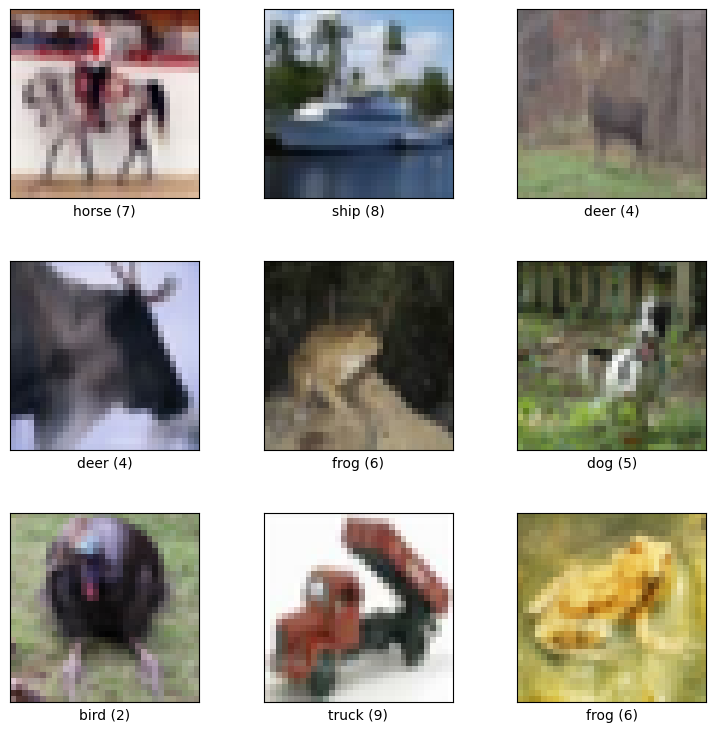

Epoch 1/10
1800/1800 [==============================] - 73s 36ms/step - loss: 0.5639 - accuracy: 0.8087 - val_loss: 0.4554 - val_accuracy: 0.8364
Epoch 2/10
1800/1800 [==============================] - 66s 36ms/step - loss: 0.4359 - accuracy: 0.8494 - val_loss: 0.4368 - val_accuracy: 0.8474
Epoch 3/10
1800/1800 [==============================] - 61s 34ms/step - loss: 0.4035 - accuracy: 0.8610 - val_loss: 0.4345 - val_accuracy: 0.8492
Epoch 4/10
1800/1800 [==============================] - 68s 37ms/step - loss: 0.3841 - accuracy: 0.8672 - val_loss: 0.4381 - val_accuracy: 0.8514
Epoch 5/10
1800/1800 [==============================] - 66s 37ms/step - loss: 0.3665 - accuracy: 0.8728 - val_loss: 0.4266 - val_accuracy: 0.8562
Epoch 6/10
1800/1800 [==============================] - 67s 37ms/step - loss: 0.3534 - accuracy: 0.8778 - val_loss: 0.4607 - val_accuracy: 0.8488
Epoch 7/10
1800/1800 [==============================] - 65s 36ms/step - loss: 0.3462 - accuracy: 0.8813 - val_loss: 0.4459 -

In [ ]:
###############################
#
# cifar
#
################################

import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

#244x 244 사이즈로 리사이즈를 하고, 정규화를 해줍니다.
def format_image(image,label):
    image = tf.image.resize(image,(224,224))/255.0
    return image, label

#훈련, 검증, 테스트 세트로 나눕니다.
(raw_train, raw_validation, raw_test), metadata =tfds.load(
    'cifar10',
    split=['train[:90%]','train[90%:]','test[:10%]'],
    with_info=True,
    as_supervised=True,
)

print(metadata)

num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes
class_names =metadata.features['label'].names
print(class_names)

fig = tfds.show_examples(raw_train, metadata)

BATCH_SIZE = 25
train_batches = raw_train.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)

test_batches = raw_test.map(format_image).batch(1)


####################
#케라스 허브에서 모델 가져오기
###################

model = tf.keras.Sequential([
    hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/tf2-preview-feature-vector/versions/4",
                   input_shape = (224,224,3),
                   output_shape=[1280],
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


# model = tf.keras.Sequential([
#     hub.KerasLayer("https://tfhub.dev/google/aiy/vision/classifier/food_V1/1",
#                    input_shape = (192,192,3),
#                     output_shape=[2024],
#                    trainable=False
#                    ),  # Can be True, see below.
#     tf.keras.layers.Dense(num_classes, activation='softmax')
# ])

model.compile(
    optimizer='adam',
    loss ='sparse_categorical_crossentropy',
    metrics =['accuracy']
)

hist = model.fit(
    train_batches,
    epochs = 10,
    validation_data = validation_batches
)

model.summary()

#학습된 모델 저장하기
CATS_VS_DOGS_SAVED_MODEL = "/content/drive/MyDrive/INTEL_PYTHON/cifar_saved_model"
tf.saved_model.save(model, CATS_VS_DOGS_SAVED_MODEL)

#tensoflow lite로 변환하기
converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
tflite_model_file = '/content/drive/MyDrive/INTEL_PYTHON/cifar_converted_model.tflite'

#with open(…) as f 에서 f는 open(…)함수가 리턴한 file object.
with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)


interpreter = tf.lite.Interpreter(model_content=tflite_model)
input_details = interpreter.get_input_details()[0]
print('input: ', input_details)
output_details = interpreter.get_output_details()[0]
print('output: ', output_details)



0
177
100개 중 맞은 예측 수: 84


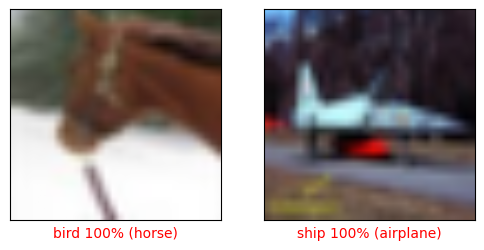

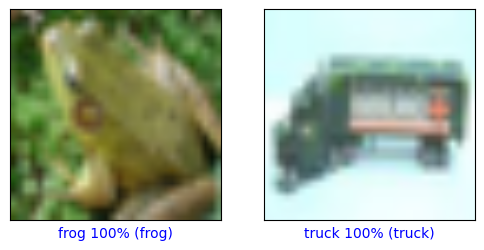

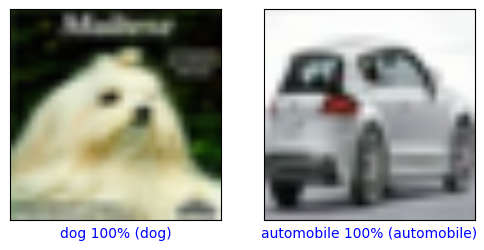

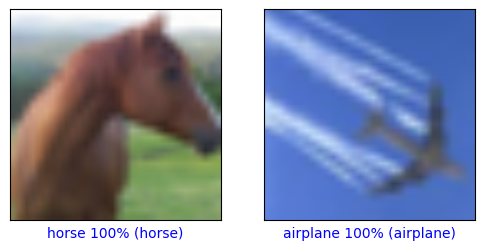

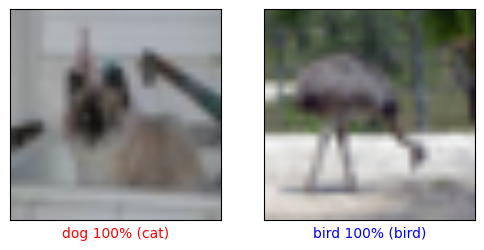

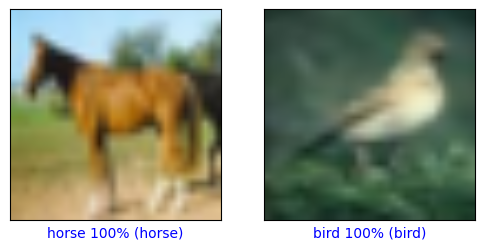

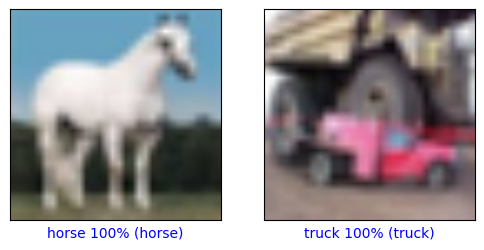

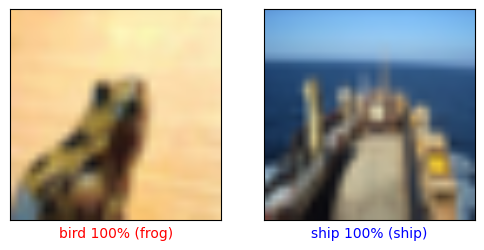

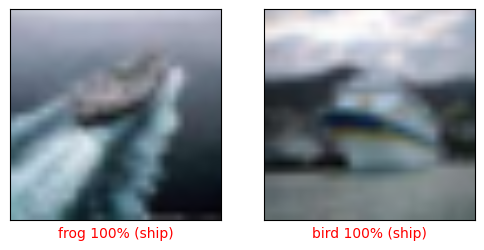

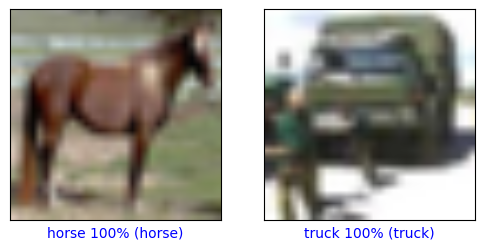

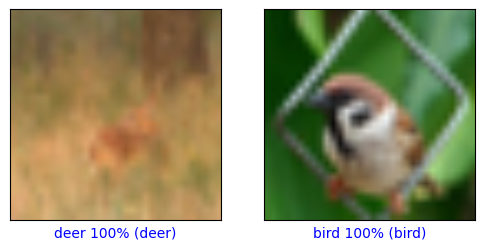

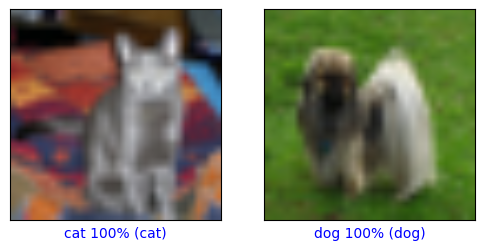

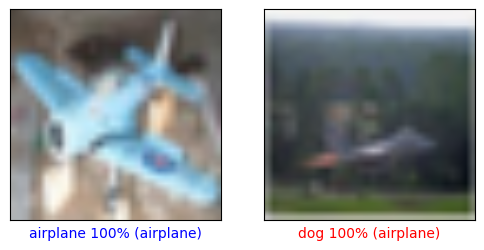

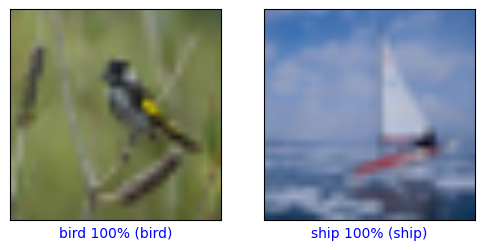

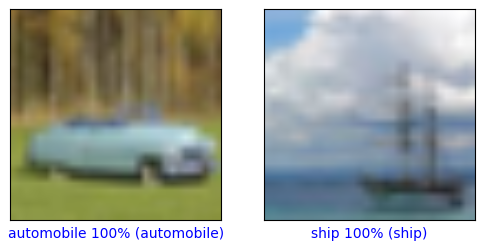

In [ ]:
###########################
## 라즈베리 파이에서 실행할 파일
###########################

import tensorflow as tf
import tflite_runtime.interpreter as tflite
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt


#모델 로드
#interpreter = tf.lite.Interpreter(model_path='/content/drive/MyDrive/INTEL_PYTHON/converted_model.tflite')
interpreter = tflite.Interpreter(model_path='/content/drive/MyDrive/INTEL_PYTHON/cifar_converted_model.tflite')

#텐서 할당
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

predictions =[]

print(input_index)
print(output_index)

#테스트 해보기
#테스트 배치 파일을 100개 씩 가져와서
predictions =[]
test_labels, test_imgs = [],[]
for img, label in test_batches.take(100):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)


#예측 수 비교
score  = 0
for item in range(0,100):
    prediction = np.argmax(predictions[item])
    label = test_labels[item]
    if prediction == label:
        score = score +1


print("100개 중 맞은 예측 수: "+ str(score))


def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    # 't' is a tensor of shape [1, 2, 1, 3, 1, 1]
    img = tf.squeeze(img) # [2, 3]

    plt.imshow(img)

    predicted_label = np.argmax(predictions_array[index])
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                    100*np.max(predictions_array),
                                    class_names[true_label]),
                                    color=color)


for index in range(0,30):

    if index%2 == 0 :
      plt.figure(figsize = (6,3))
      plt.subplot(121)
    elif index %2 ==1 :
      plt.subplot(122)

    plot_image(index, predictions, test_labels, test_imgs)
    if index %2 ==1:
      plt.show()
      #imgFile = 'resultImg/result{}.png'.format(index)
      #plt.savefig(imgFile)




In [ ]:
###############################
#
# cifar
#
################################

import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

#244x 244 사이즈로 리사이즈를 하고, 정규화를 해줍니다.
def format_image(image,label):
    image = tf.image.resize(image,(224,224))/255.0
    return image, label

#훈련, 검증, 테스트 세트로 나눕니다.
(raw_train, raw_validation, raw_test), metadata =tfds.load(
    'eurosat',
    split=['train[:80%]','train[80%:90%]','train[90%:]'],
    with_info=True,
    as_supervised=True,
)

print(metadata)

num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes
class_names =metadata.features['label'].names
print(class_names)

fig = tfds.show_examples(raw_train, metadata)

BATCH_SIZE = 30
train_batches = raw_train.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)

test_batches = raw_test.map(format_image).batch(1)


####################
#케라스 허브에서 모델 가져오기
###################
#"https://tfhub.dev/google/aiy/vision/classifier/food_V1/1",
model = tf.keras.Sequential([
    hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/tf2-preview-feature-vector/versions/4",
                   input_shape = (224,224,3),
                   output_shape=[1280],
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss ='sparse_categorical_crossentropy',
    metrics =['accuracy']
)

hist = model.fit(
    train_batches,
    epochs = 10,
    validation_data = validation_batches
)

model.summary()

#학습된 모델 저장하기
CATS_VS_DOGS_SAVED_MODEL = "/content/drive/MyDrive/INTEL_PYTHON/eurosat_saved_model"
tf.saved_model.save(model, CATS_VS_DOGS_SAVED_MODEL)

#tensoflow lite로 변환하기
converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
tflite_model_file = '/content/drive/MyDrive/INTEL_PYTHON/eurosat_converted_model.tflite'

#with open(…) as f 에서 f는 open(…)함수가 리턴한 file object.
with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)


interpreter = tf.lite.Interpreter(model_content=tflite_model)
input_details = interpreter.get_input_details()[0]
print('input: ', input_details)
output_details = interpreter.get_output_details()[0]
print('output: ', output_details)


###########################
## 라즈베리 파이에서 실행할 파일
###########################

import tensorflow as tf
import tflite_runtime.interpreter as tflite
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt


#모델 로드
#interpreter = tf.lite.Interpreter(model_path='/content/drive/MyDrive/INTEL_PYTHON/converted_model.tflite')
interpreter = tflite.Interpreter(model_path='/content/drive/MyDrive/INTEL_PYTHON/eurosat_converted_model.tflite')

#텐서 할당
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

predictions =[]

print(input_index)
print(output_index)

#테스트 해보기
#테스트 배치 파일을 100개 씩 가져와서
predictions =[]
test_labels, test_imgs = [],[]
for img, label in test_batches.take(100):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)


#예측 수 비교
score  = 0
for item in range(0,100):
    prediction = np.argmax(predictions[item])
    label = test_labels[item]
    if prediction == label:
        score = score +1


print("100개 중 맞은 예측 수: "+ str(score))


def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    # 't' is a tensor of shape [1, 2, 1, 3, 1, 1]
    img = tf.squeeze(img) # [2, 3]

    plt.imshow(img)

    predicted_label = np.argmax(predictions_array[index])
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                    100*np.max(predictions_array),
                                    class_names[true_label]),
                                    color=color)


for index in range(0,30):

    if index%2 == 0 :
      plt.figure(figsize = (6,3))
      plt.subplot(121)
    elif index %2 ==1 :
      plt.subplot(122)

    plot_image(index, predictions, test_labels, test_imgs)
    if index %2 ==1:
      plt.show()
      #imgFile = 'resultImg/result{}.png'.format(index)
      #plt.savefig(imgFile)





Output hidden; open in https://colab.research.google.com to view.

In [ ]:
###############################
#
# food 101
#
################################

import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tflite_runtime.interpreter as tflite

#244x 244 사이즈로 리사이즈를 하고, 정규화를 해줍니다.
def format_image(image,label):
    image = tf.image.resize(image,(224,224))/255.0
    return image, label

#훈련, 검증, 테스트 세트로 나눕니다.
(raw_train, raw_validation, raw_test), metadata =tfds.load(
    'food101',
    split=['train[:80%]','train[80%:90%]','train[90%:]'],
    with_info=True,
    as_supervised=True,
)

print(metadata)

num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes
class_names =metadata.features['label'].names
print(class_names)

fig = tfds.show_examples(raw_train, metadata)

BATCH_SIZE = 30
train_batches = raw_train.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)

test_batches = raw_test.map(format_image).batch(1)


####################
#케라스 허브에서 모델 가져오기
###################
#"https://tfhub.dev/google/aiy/vision/classifier/food_V1/1",
model = tf.keras.Sequential([
    hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/tf2-preview-feature-vector/versions/4",
                   input_shape = (224,224,3),
                   output_shape=[1280],
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss ='sparse_categorical_crossentropy',
    metrics =['accuracy']
)

hist = model.fit(
    train_batches,
    epochs = 10,
    validation_data = validation_batches
)

model.summary()

#학습된 모델 저장하기
CATS_VS_DOGS_SAVED_MODEL = "/content/drive/MyDrive/INTEL_PYTHON/food_saved_model"
tf.saved_model.save(model, CATS_VS_DOGS_SAVED_MODEL)

#tensoflow lite로 변환하기
converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
tflite_model_file = '/content/drive/MyDrive/INTEL_PYTHON/food_converted_model.tflite'

#with open(…) as f 에서 f는 open(…)함수가 리턴한 file object.
with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)


interpreter = tf.lite.Interpreter(model_content=tflite_model)
input_details = interpreter.get_input_details()[0]
print('input: ', input_details)
output_details = interpreter.get_output_details()[0]
print('output: ', output_details)


###########################
## 라즈베리 파이에서 실행할 파일
###########################

#모델 로드
#interpreter = tf.lite.Interpreter(model_path='/content/drive/MyDrive/INTEL_PYTHON/converted_model.tflite')
interpreter = tflite.Interpreter(model_path='/content/drive/MyDrive/INTEL_PYTHON/food_converted_model.tflite')

#텐서 할당
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

predictions =[]

print(input_index)
print(output_index)

#테스트 해보기
#테스트 배치 파일을 100개 씩 가져와서
predictions =[]
test_labels, test_imgs = [],[]
for img, label in test_batches.take(100):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)


#예측 수 비교
score  = 0
for item in range(0,100):
    prediction = np.argmax(predictions[item])
    label = test_labels[item]
    if prediction == label:
        score = score +1


print("100개 중 맞은 예측 수: "+ str(score))


def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    # 't' is a tensor of shape [1, 2, 1, 3, 1, 1]
    img = tf.squeeze(img) # [2, 3]

    plt.imshow(img)

    predicted_label = np.argmax(predictions_array[index])
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                    100*np.max(predictions_array),
                                    class_names[true_label]),
                                    color=color)


for index in range(0,30):

    if index%2 == 0 :
      plt.figure(figsize = (6,3))
      plt.subplot(121)
    elif index %2 ==1 :
      plt.subplot(122)

    plot_image(index, predictions, test_labels, test_imgs)
    if index %2 ==1:
      plt.show()
      #imgFile = 'resultImg/result{}.png'.format(index)
      #plt.savefig(imgFile)





Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incomplete7LLYMV/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir=PosixGPath('/tmp/tmpov4oyzdstfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolu

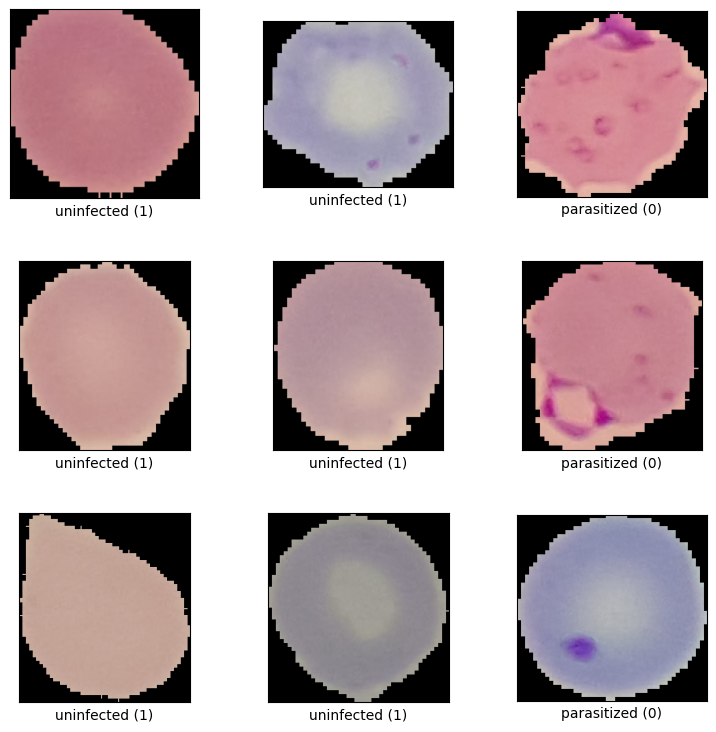

Epoch 1/5
689/689 [==============================] - 78s 89ms/step - loss: 0.2088 - accuracy: 0.9212 - val_loss: 0.1560 - val_accuracy: 0.9398
Epoch 2/5
689/689 [==============================] - 49s 62ms/step - loss: 0.1662 - accuracy: 0.9406 - val_loss: 0.1661 - val_accuracy: 0.9441
Epoch 3/5
689/689 [==============================] - 34s 45ms/step - loss: 0.1582 - accuracy: 0.9438 - val_loss: 0.1462 - val_accuracy: 0.9488
Epoch 4/5
689/689 [==============================] - 39s 51ms/step - loss: 0.1480 - accuracy: 0.9481 - val_loss: 0.1491 - val_accuracy: 0.9452
Epoch 5/5
689/689 [==============================] - 46s 62ms/step - loss: 0.1428 - accuracy: 0.9492 - val_loss: 0.1404 - val_accuracy: 0.9503
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 

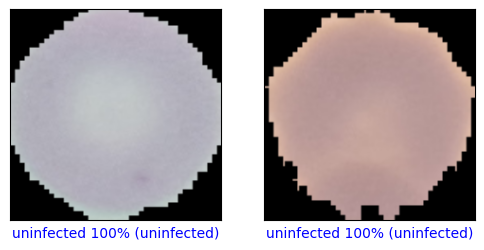

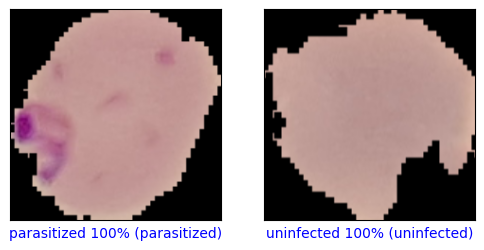

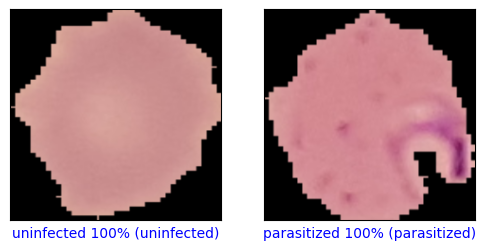

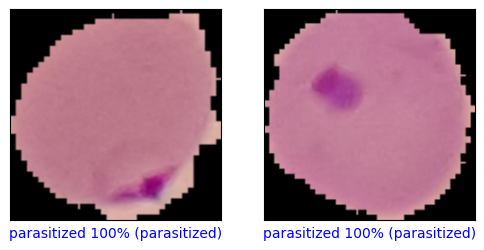

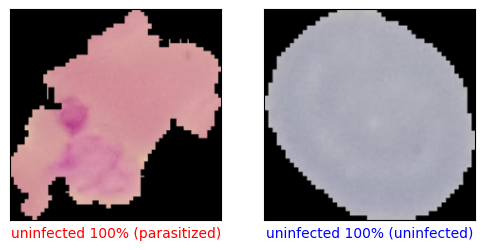

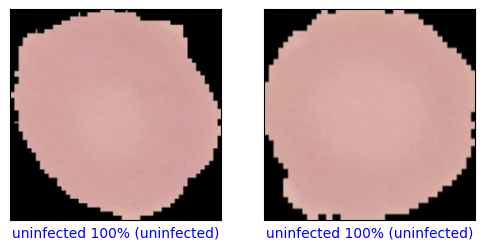

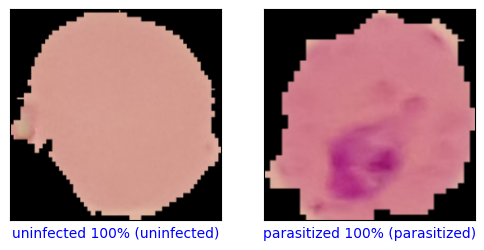

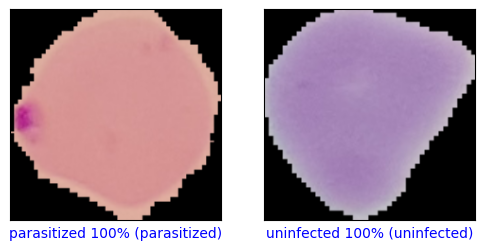

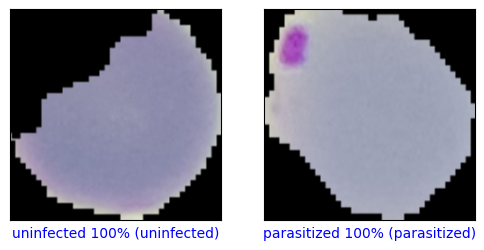

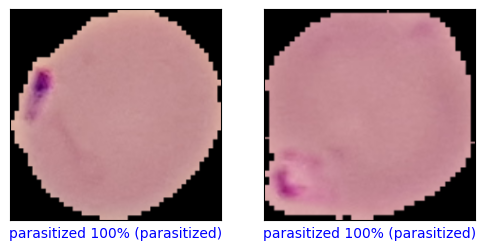

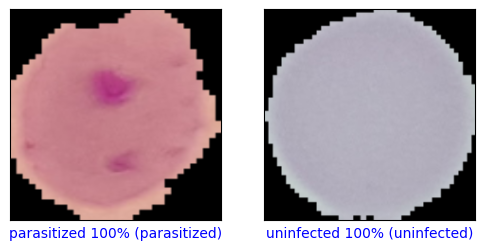

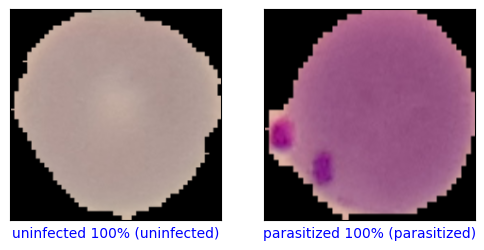

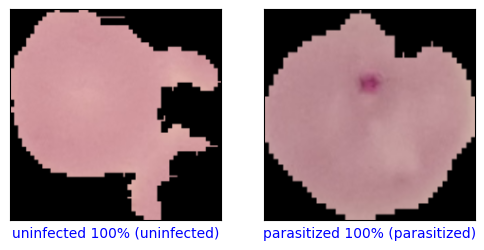

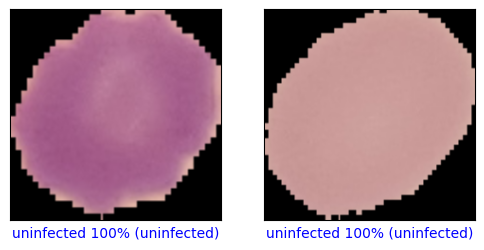

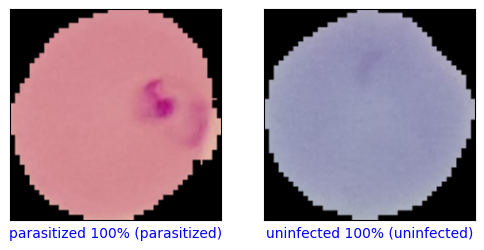

In [ ]:
###############################
#
# 말라리아 malaria
#
################################

import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tflite_runtime.interpreter as tflite

#244x 244 사이즈로 리사이즈를 하고, 정규화를 해줍니다.
def format_image(image,label):
    image = tf.image.resize(image,(224,224))/255.0
    return image, label

#훈련, 검증, 테스트 세트로 나눕니다.
(raw_train, raw_validation, raw_test), metadata =tfds.load(
    'malaria',
    split=['train[:80%]','train[80%:90%]','train[90%:]'],
    with_info=True,
    as_supervised=True,
)

print(metadata)

num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes
class_names =metadata.features['label'].names
print(class_names)

fig = tfds.show_examples(raw_train, metadata)

BATCH_SIZE = 32
train_batches = raw_train.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)

test_batches = raw_test.map(format_image).batch(1)


####################
#케라스 허브에서 모델 가져오기
###################
#"https://tfhub.dev/google/aiy/vision/classifier/food_V1/1",
model = tf.keras.Sequential([
    hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/tf2-preview-feature-vector/versions/4",
                   input_shape = (224,224,3),
                   output_shape=[1280],
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss ='sparse_categorical_crossentropy',
    metrics =['accuracy']
)

hist = model.fit(
    train_batches,
    epochs = 5,
    validation_data = validation_batches
)

model.summary()

#학습된 모델 저장하기
CATS_VS_DOGS_SAVED_MODEL = "/content/drive/MyDrive/INTEL_PYTHON/malaria_saved_model"
tf.saved_model.save(model, CATS_VS_DOGS_SAVED_MODEL)

#tensoflow lite로 변환하기
converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
tflite_model_file = '/content/drive/MyDrive/INTEL_PYTHON/malaria_converted_model.tflite'

#with open(…) as f 에서 f는 open(…)함수가 리턴한 file object.
with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)


interpreter = tf.lite.Interpreter(model_content=tflite_model)
input_details = interpreter.get_input_details()[0]
print('input: ', input_details)
output_details = interpreter.get_output_details()[0]
print('output: ', output_details)


###########################
## 라즈베리 파이에서 실행할 파일
###########################

#모델 로드
#interpreter = tf.lite.Interpreter(model_path='/content/drive/MyDrive/INTEL_PYTHON/converted_model.tflite')
interpreter = tflite.Interpreter(model_path='/content/drive/MyDrive/INTEL_PYTHON/malaria_converted_model.tflite')

#텐서 할당
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

predictions =[]

print(input_index)
print(output_index)

#테스트 해보기
#테스트 배치 파일을 100개 씩 가져와서
predictions =[]
test_labels, test_imgs = [],[]
for img, label in test_batches.take(100):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)


#예측 수 비교
score  = 0
for item in range(0,100):
    prediction = np.argmax(predictions[item])
    label = test_labels[item]
    if prediction == label:
        score = score +1


print("100개 중 맞은 예측 수: "+ str(score))


def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    # 't' is a tensor of shape [1, 2, 1, 3, 1, 1]
    img = tf.squeeze(img) # [2, 3]

    plt.imshow(img)

    predicted_label = np.argmax(predictions_array[index])
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                    100*np.max(predictions_array),
                                    class_names[true_label]),
                                    color=color)


for index in range(0,30):

    if index%2 == 0 :
      plt.figure(figsize = (6,3))
      plt.subplot(121)
    elif index %2 ==1 :
      plt.subplot(122)

    plot_image(index, predictions, test_labels, test_imgs)
    if index %2 ==1:
      plt.show()
      #imgFile = 'resultImg/result{}.png'.format(index)
      #plt.savefig(imgFile)





In [ ]:
###############################
#
# quickdraw_bitmap
#
################################

import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tflite_runtime.interpreter as tflite

#244x 244 사이즈로 리사이즈를 하고, 정규화를 해줍니다.
def format_image(image,label):
    image = tf.image.resize(image,(224,224))/255.0
    return image, label

#훈련, 검증, 테스트 세트로 나눕니다.
(raw_train, raw_validation, raw_test), metadata =tfds.load(
    'quickdraw_bitmap',
    split=['train[:15000]','train[16000:17000]','train[18000:19000]'],
    with_info=True,
    as_supervised=True,
)

print(metadata)

num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes
class_names =metadata.features['label'].names
print(class_names)

fig = tfds.show_examples(raw_train, metadata)

BATCH_SIZE = 32
train_batches = raw_train.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)

test_batches = raw_test.map(format_image).batch(1)


####################
#케라스 허브에서 모델 가져오기
###################
#"https://tfhub.dev/google/aiy/vision/classifier/food_V1/1",
model = tf.keras.Sequential([
    hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/tf2-preview-feature-vector/versions/4",
                   input_shape = (224,224,3),
                   output_shape=[1280],
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss ='sparse_categorical_crossentropy',
    metrics =['accuracy']
)

hist = model.fit(
    train_batches,
    epochs = 5,
    validation_data = validation_batches
)

model.summary()

#학습된 모델 저장하기
CATS_VS_DOGS_SAVED_MODEL = "/content/drive/MyDrive/INTEL_PYTHON/quickdraw_bitmap_saved_model"
tf.saved_model.save(model, CATS_VS_DOGS_SAVED_MODEL)

#tensoflow lite로 변환하기
converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
tflite_model_file = '/content/drive/MyDrive/INTEL_PYTHON/quickdraw_bitmap_converted_model.tflite'

#with open(…) as f 에서 f는 open(…)함수가 리턴한 file object.
with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)


interpreter = tf.lite.Interpreter(model_content=tflite_model)
input_details = interpreter.get_input_details()[0]
print('input: ', input_details)
output_details = interpreter.get_output_details()[0]
print('output: ', output_details)


###########################
## 라즈베리 파이에서 실행할 파일
###########################

#모델 로드
#interpreter = tf.lite.Interpreter(model_path='/content/drive/MyDrive/INTEL_PYTHON/converted_model.tflite')
interpreter = tflite.Interpreter(model_path='/content/drive/MyDrive/INTEL_PYTHON/quickdraw_bitmap_converted_model.tflite')

#텐서 할당
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

predictions =[]

print(input_index)
print(output_index)

#테스트 해보기
#테스트 배치 파일을 100개 씩 가져와서
predictions =[]
test_labels, test_imgs = [],[]
for img, label in test_batches.take(100):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)


#예측 수 비교
score  = 0
for item in range(0,100):
    prediction = np.argmax(predictions[item])
    label = test_labels[item]
    if prediction == label:
        score = score +1


print("100개 중 맞은 예측 수: "+ str(score))


def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    # 't' is a tensor of shape [1, 2, 1, 3, 1, 1]
    img = tf.squeeze(img) # [2, 3]

    plt.imshow(img)

    predicted_label = np.argmax(predictions_array[index])
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                    100*np.max(predictions_array),
                                    class_names[true_label]),
                                    color=color)


for index in range(0,30):

    if index%2 == 0 :
      plt.figure(figsize = (6,3))
      plt.subplot(121)
    elif index %2 ==1 :
      plt.subplot(122)

    plot_image(index, predictions, test_labels, test_imgs)
    if index %2 ==1:
      plt.show()
      #imgFile = 'resultImg/result{}.png'.format(index)
      #plt.savefig(imgFile)





Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50426266 [00:00<?, ? examples/s]

KeyboardInterrupt: 

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2520 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteXIJIJO/rock_paper_scissors-train.tfrec…

Generating test examples...:   0%|          | 0/372 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteXIJIJO/rock_paper_scissors-test.tfreco…

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_dir=PosixGPath('/tmp/tmpue9qur2jtfds'),
    file_format=tfrecord,
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Sciss

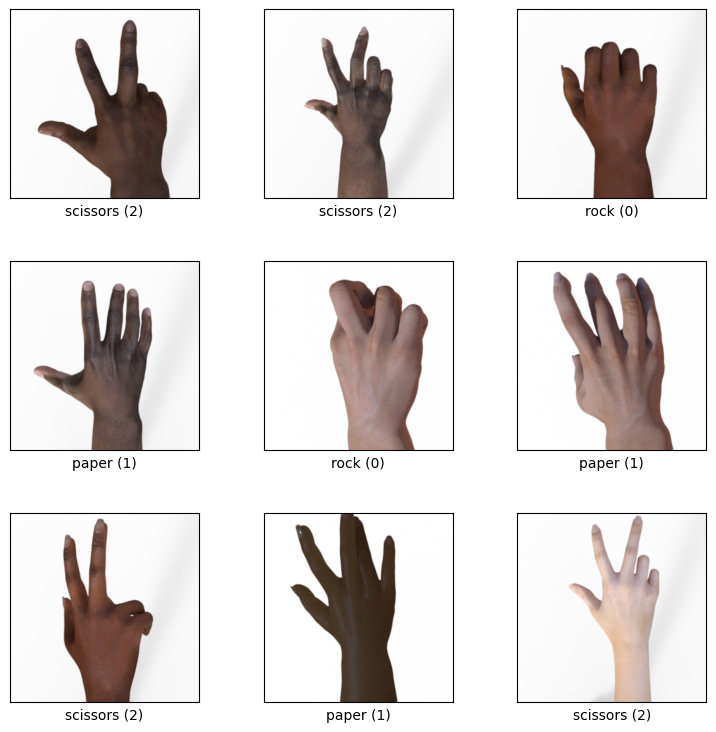

Epoch 1/5
75/75 [==============================] - 66s 748ms/step - loss: 0.2759 - accuracy: 0.9357 - val_loss: 0.0652 - val_accuracy: 0.9921
Epoch 2/5
75/75 [==============================] - 51s 686ms/step - loss: 0.0513 - accuracy: 0.9979 - val_loss: 0.0297 - val_accuracy: 1.0000
Epoch 3/5
75/75 [==============================] - 57s 762ms/step - loss: 0.0280 - accuracy: 0.9996 - val_loss: 0.0184 - val_accuracy: 1.0000
Epoch 4/5
75/75 [==============================] - 58s 773ms/step - loss: 0.0178 - accuracy: 1.0000 - val_loss: 0.0126 - val_accuracy: 1.0000
Epoch 5/5
75/75 [==============================] - 60s 802ms/step - loss: 0.0129 - accuracy: 1.0000 - val_loss: 0.0101 - val_accuracy: 1.0000
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense

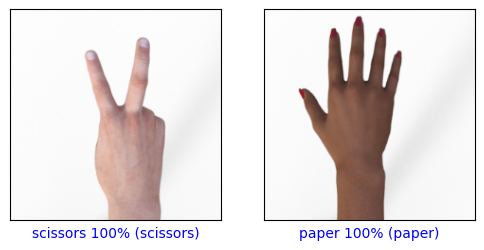

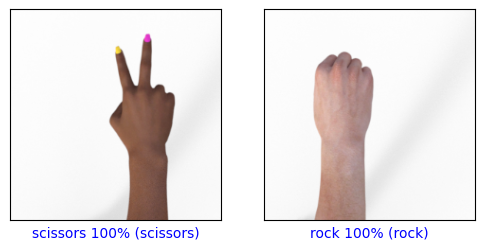

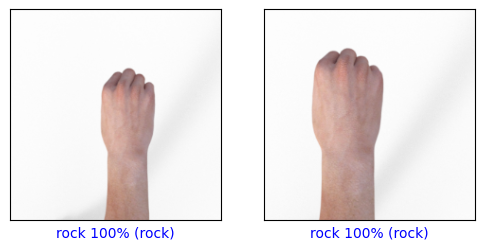

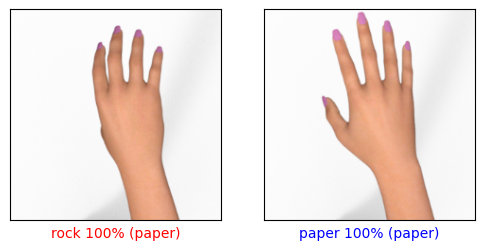

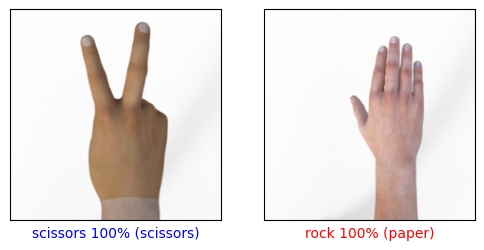

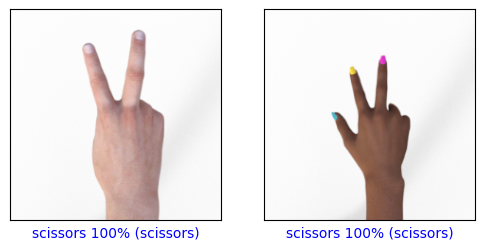

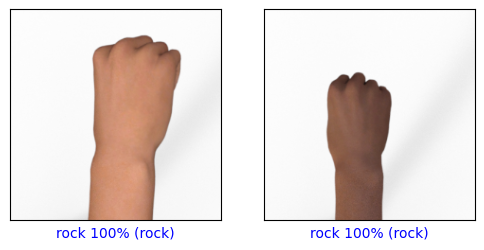

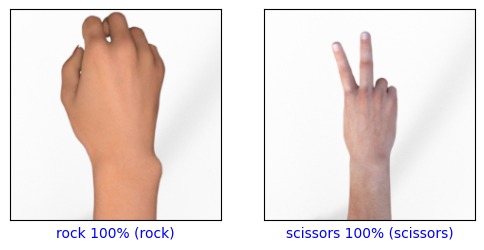

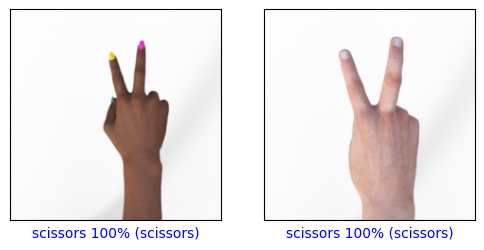

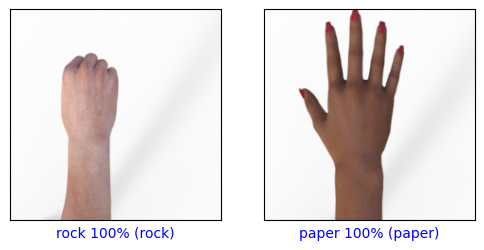

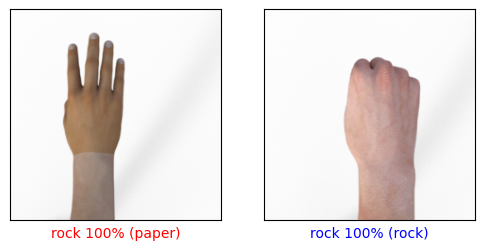

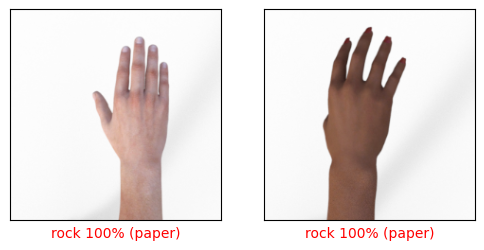

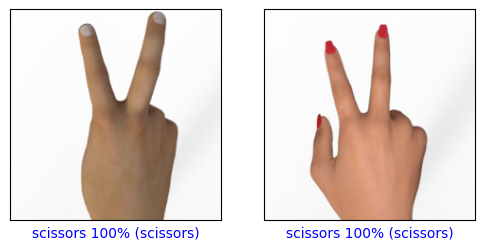

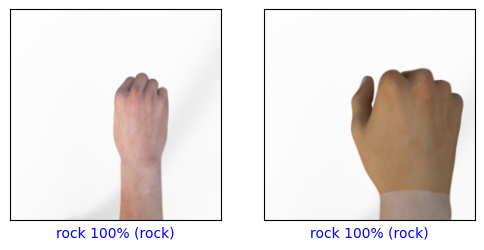

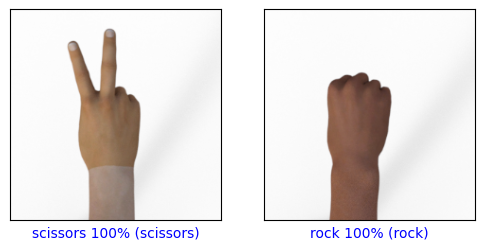

In [ ]:
###############################
#
# rock_paper_scissors
#
################################

import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tflite_runtime.interpreter as tflite

#244x 244 사이즈로 리사이즈를 하고, 정규화를 해줍니다.
def format_image(image,label):
    image = tf.image.resize(image,(224,224))/255.0
    return image, label

#훈련, 검증, 테스트 세트로 나눕니다.
(raw_train, raw_validation, raw_test), metadata =tfds.load(
    'rock_paper_scissors',
    split=['train[:95%]','train[95%:]','test'],
    with_info=True,
    as_supervised=True,
)

print(metadata)

num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes
class_names =metadata.features['label'].names
print(class_names)

fig = tfds.show_examples(raw_train, metadata)

BATCH_SIZE = 32
train_batches = raw_train.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)

test_batches = raw_test.map(format_image).batch(1)


####################
#케라스 허브에서 모델 가져오기
###################
#"https://tfhub.dev/google/aiy/vision/classifier/food_V1/1",
model = tf.keras.Sequential([
    hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/tf2-preview-feature-vector/versions/4",
                   input_shape = (224,224,3),
                   output_shape=[1280],
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss ='sparse_categorical_crossentropy',
    metrics =['accuracy']
)

hist = model.fit(
    train_batches,
    epochs = 5,
    validation_data = validation_batches
)

model.summary()

#학습된 모델 저장하기
CATS_VS_DOGS_SAVED_MODEL = "/content/drive/MyDrive/INTEL_PYTHON/rock_paper_scissors_bitmap_saved_model"
tf.saved_model.save(model, CATS_VS_DOGS_SAVED_MODEL)

#tensoflow lite로 변환하기
converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
tflite_model_file = '/content/drive/MyDrive/INTEL_PYTHON/rock_paper_scissors_converted_model.tflite'

#with open(…) as f 에서 f는 open(…)함수가 리턴한 file object.
with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)


interpreter = tf.lite.Interpreter(model_content=tflite_model)
input_details = interpreter.get_input_details()[0]
print('input: ', input_details)
output_details = interpreter.get_output_details()[0]
print('output: ', output_details)


###########################
## 라즈베리 파이에서 실행할 파일
###########################

#모델 로드
#interpreter = tf.lite.Interpreter(model_path='/content/drive/MyDrive/INTEL_PYTHON/converted_model.tflite')
interpreter = tflite.Interpreter(model_path='/content/drive/MyDrive/INTEL_PYTHON/rock_paper_scissors_converted_model.tflite')

#텐서 할당
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

predictions =[]

print(input_index)
print(output_index)

#테스트 해보기
#테스트 배치 파일을 100개 씩 가져와서
predictions =[]
test_labels, test_imgs = [],[]
for img, label in test_batches.take(100):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)


#예측 수 비교
score  = 0
for item in range(0,100):
    prediction = np.argmax(predictions[item])
    label = test_labels[item]
    if prediction == label:
        score = score +1


print("100개 중 맞은 예측 수: "+ str(score))


def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    # 't' is a tensor of shape [1, 2, 1, 3, 1, 1]
    img = tf.squeeze(img) # [2, 3]

    plt.imshow(img)

    predicted_label = np.argmax(predictions_array[index])
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                    100*np.max(predictions_array),
                                    class_names[true_label]),
                                    color=color)


for index in range(0,30):

    if index%2 == 0 :
      plt.figure(figsize = (6,3))
      plt.subplot(121)
    elif index %2 ==1 :
      plt.subplot(122)

    plot_image(index, predictions, test_labels, test_imgs)
    if index %2 ==1:
      plt.show()
      #imgFile = 'resultImg/result{}.png'.format(index)
      #plt.savefig(imgFile)





In [ ]:
###############################
#dtd
#
################################

import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tflite_runtime.interpreter as tflite

#244x 244 사이즈로 리사이즈를 하고, 정규화를 해줍니다.
def format_image(image,label):
    image = tf.image.resize(image,(224,224))/255.0
    return image, label

#훈련, 검증, 테스트 세트로 나눕니다.
(raw_train, raw_validation, raw_test), metadata =tfds.load(
    'dtd',
    split=['train','validation','test'],
    with_info=True,
    as_supervised=True,
)

print(metadata)

num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes
class_names =metadata.features['label'].names
print(class_names)

fig = tfds.show_examples(raw_train, metadata)

BATCH_SIZE = 32
train_batches = raw_train.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)

test_batches = raw_test.map(format_image).batch(1)


####################
#케라스 허브에서 모델 가져오기
###################
#"https://tfhub.dev/google/aiy/vision/classifier/food_V1/1",
model = tf.keras.Sequential([
    hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/tf2-preview-feature-vector/versions/4",
                   input_shape = (224,224,3),
                   output_shape=[1280],
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss ='sparse_categorical_crossentropy',
    metrics =['accuracy']
)

hist = model.fit(
    train_batches,
    epochs = 5,
    validation_data = validation_batches
)

model.summary()

#학습된 모델 저장하기
CATS_VS_DOGS_SAVED_MODEL = "/content/drive/MyDrive/INTEL_PYTHON/dtd_saved_model"
tf.saved_model.save(model, CATS_VS_DOGS_SAVED_MODEL)

#tensoflow lite로 변환하기
converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
tflite_model_file = '/content/drive/MyDrive/INTEL_PYTHON/dtd_converted_model.tflite'

#with open(…) as f 에서 f는 open(…)함수가 리턴한 file object.
with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)


interpreter = tf.lite.Interpreter(model_content=tflite_model)
input_details = interpreter.get_input_details()[0]
print('input: ', input_details)
output_details = interpreter.get_output_details()[0]
print('output: ', output_details)


###########################
## 라즈베리 파이에서 실행할 파일
###########################

#모델 로드
#interpreter = tf.lite.Interpreter(model_path='/content/drive/MyDrive/INTEL_PYTHON/converted_model.tflite')
interpreter = tflite.Interpreter(model_path='/content/drive/MyDrive/INTEL_PYTHON/dtd_converted_model.tflite')

#텐서 할당
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

predictions =[]

print(input_index)
print(output_index)

#테스트 해보기
#테스트 배치 파일을 100개 씩 가져와서
predictions =[]
test_labels, test_imgs = [],[]
for img, label in test_batches.take(100):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)


#예측 수 비교
score  = 0
for item in range(0,100):
    prediction = np.argmax(predictions[item])
    label = test_labels[item]
    if prediction == label:
        score = score +1


print("100개 중 맞은 예측 수: "+ str(score))


def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    # 't' is a tensor of shape [1, 2, 1, 3, 1, 1]
    img = tf.squeeze(img) # [2, 3]

    plt.imshow(img)

    predicted_label = np.argmax(predictions_array[index])
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                    100*np.max(predictions_array),
                                    class_names[true_label]),
                                    color=color)


for index in range(0,30):

    if index%2 == 0 :
      plt.figure(figsize = (6,3))
      plt.subplot(121)
    elif index %2 ==1 :
      plt.subplot(122)

    plot_image(index, predictions, test_labels, test_imgs)
    if index %2 ==1:
      plt.show()
      #imgFile = 'resultImg/result{}.png'.format(index)
      #plt.savefig(imgFile)





ValueError: as_supervised=True but dtd does not support a supervised structure.

https://www.tensorflow.org/datasets/catalog/cifar10?hl=en

##cifar 저용량 사진은  모델에 어떻게 적용해야 하는